# Project

Import necessary packages for the model.

In [27]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd 
import numpy as np
import requests
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import parfit.parfit as pf
import time
import dill

Use requests and read_csv to pull data into a Pandas DataFrame.

In [2]:
url=('https://www.dropbox.com/s/00gouxpr9bueb7t/PitchData_v2.csv?dl=1')
resp = requests.get(url).content
raw_data = pd.read_csv(io.StringIO(resp.decode('utf-8')), na_values = ['NULL'])
raw_data.columns = map(str.lower, raw_data.columns)

Formatting the data for usage in the model. I'm binarizing all of the categorical data and filtering through the outcomes. For this model, I'm just using swings. I found that adding the batter's decision to swing added too much uncertainty to reliably predict anything. Rather, I'm trying to predict if he missed with his decided on swing.

In [3]:
print(raw_data.pitchresult.value_counts())
outcome_dict = {'Ball': np.nan,'BlockedBall': np.nan,'CalledStrike': np.nan,'Foul': 0,'FoulBunt': np.nan,'FoulTip': 0,'FoulTipBunt': np.nan,'HitByPitch': np.nan,'InPlay': 0,'MissedBunt': np.nan,'Pitchout': np.nan,'SwingingStrike': 1,'SwingPitchout': 1,'SwingStrikeBlk': 1}
hand_dict = {'R': 0, 'L': 1}
raw_data.pitchresult = raw_data.pitchresult.map(outcome_dict)
raw_data.batside = raw_data.batside.map(hand_dict)
raw_data.pitchhand = raw_data.pitchhand.map(hand_dict)

Ball              166008
Foul               90735
CalledStrike       89109
InPlay             87772
SwingingStrike     41723
BlockedBall         7284
FoulTip             4368
SwingStrikeBlk      2215
FoulBunt            1682
HitByPitch          1212
MissedBunt           308
FoulTipBunt           34
Pitchout               3
SwingPitchout          3
Name: pitchresult, dtype: int64


Removing NaNs and non-fastballs from the dataset. The NaNs were a surprsingly small part of the dataset, so it wasn't necessary to impute the values.

In [4]:
raw_data = raw_data[(raw_data['pitchtype'] == 'Fastball')]
print(raw_data.pitchresult.value_counts())
raw_data = raw_data.dropna(axis = 0, how='any')
print(raw_data.pitchresult.value_counts())
raw_data = raw_data[(raw_data['releasespeed'] >= 85)]
print(raw_data.pitchresult.value_counts())

0.0    149864
1.0     26854
Name: pitchresult, dtype: int64
0.0    148507
1.0     26661
Name: pitchresult, dtype: int64
0.0    147378
1.0     26509
Name: pitchresult, dtype: int64


Storing column headers for the total model and the data we have to scale. Then taking the total model sample and transferring it to a new dataframe.

In [5]:
names = ['pitchresult','releasespeed','pitchtimetoplate','spinaxis','spinrate','horzbreakpfx','vertbreakpfx','releaseheight','releaseside','extension','vertapproachangle','horzapproachangle','batside']
scale_names = ['releasespeed','pitchtimetoplate','spinaxis','spinrate','horzbreakpfx','vertbreakpfx','releaseheight','releaseside','extension','vertapproachangle','horzapproachangle']

data = raw_data.loc[:,names].copy()
data[scale_names] = StandardScaler().fit_transform(data[scale_names])

Plotting a correlation matrix for all datapoints.

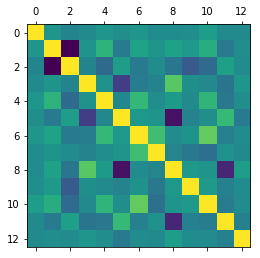

In [6]:
%matplotlib inline
plt.matshow(data.corr())

Popping out the target variable from the feature set.

In [7]:
y = data.pop('pitchresult').values
y = np.ravel(y)
print(data.shape)

(173887, 12)


Scaling the data for modeling.

In [8]:
data[scale_names] = StandardScaler().fit_transform(data[scale_names])

Splitting the data into training, validation, and test sets. 

Beginning with a Logistic Regression model as it is a simple, classification model and fits the general purpose here. Can scale upward to more complex models as well, but logistic regression provides a good starting point.

Initiating the regression models for the parfit package to optimize the hyperparameters and RFE, which is used to select the relevant features. For all models, I'm balancing the class weights since swinging strikes represent only about fifteen percent of our data, which is an extreme class imbalance.

In [21]:
X_int, X_test, y_int, y_test = train_test_split(data, y, stratify=y,test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_int, y_int, stratify=y_int, test_size=0.25)

del(X_int,y_int)

In [22]:
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(y),2),
                                                       round(len(y_val)/len(y),2),
                                                       round(len(y_test)/len(y),2)))

train: 0.6% | validation: 0.2% | test 0.2%


Setting up the parameter grid for GridSearch to tune hyperparameters.

In [43]:
logreg_grid = {
    'C': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5,
             1e-4, 1e-3, 1e-2, 1e-1, 1e0,
             1e1, 1e2, 1e3, 1e4, 1e5,
             1e6, 1e7, 1e8, 1e9, 1e10],
    'penalty': ['l2'],
    'n_jobs': [-1],
    'class_weight': ['balanced']}

logreg_paramGrid = ParameterGrid(logreg_grid)

The parfit package was used to fit the Logistic Regression and SGD models. I'm fitting it on the best AUC score, which balances Precision and Recall for the best fit. I had intended to use this to fit the Random Forest Classifier, but I had issues with pickling.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   9 out of  21 | elapsed:    6.9s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    7.3s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  15 out of  21 | elapsed:    7.5s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  18 out of  21 | elapsed:    8.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  21 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.1s finished


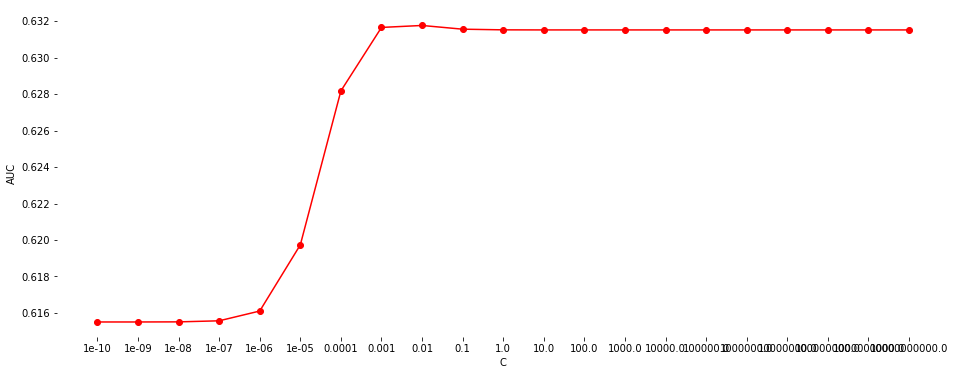

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 0.6317766432936542


In [23]:
logreg_models = pf.fitModels(LogisticRegression(), logreg_paramGrid, X_train, y_train)
logreg_scores = pf.scoreModels(logreg_models, X_val, y_val, metric=roc_auc_score, predict_proba=True)
pf.plotScores(logreg_scores, logreg_paramGrid, 'AUC')
logreg_bestModel = pf.getBestModel(logreg_models, logreg_scores, greater_is_better=True)
logreg_bestScore = pf.getBestScore(logreg_scores, greater_is_better=True)
print(logreg_bestModel, logreg_bestScore)

In [ ]:
sgd_grid = {
    'alpha': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5,
             1e-4, 1e-3, 1e-2, 1e-1, 1e0,
             1e1, 1e2, 1e3, 1e4, 1e5,
             1e6, 1e7, 1e8, 1e9, 1e10], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2','elasticnet'],
    'n_jobs': [-1],
    'class_weight': ['balanced']}

sgd_paramGrid = ParameterGrid(sgd_grid)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  32 out of  42 | elapsed: 13.2min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  37 out of  42 | elapsed: 15.0min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed: 16.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed: 16.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.6s finished


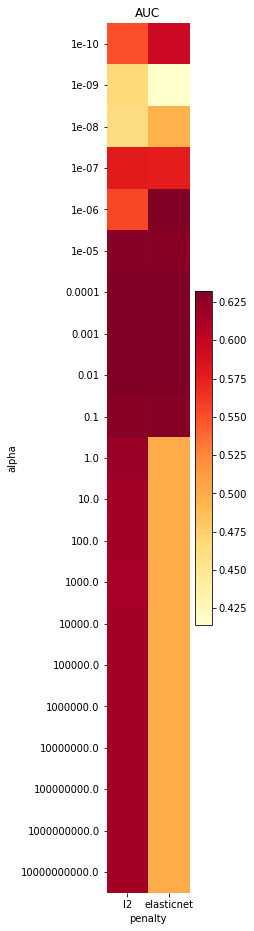

SGDClassifier(alpha=1e-06, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=1000,
       n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False) 0.6324312530492625


In [24]:
sgd_models = pf.fitModels(SGDClassifier(), sgd_paramGrid, X_train, y_train)
sgd_scores = pf.scoreModels(sgd_models, X_val, y_val, metric=roc_auc_score, predict_proba=True)
pf.plotScores(sgd_scores, sgd_paramGrid, 'AUC')
sgd_bestModel = pf.getBestModel(sgd_models, sgd_scores, greater_is_better=True)
sgd_bestScore = pf.getBestScore(sgd_scores, greater_is_better=True)
print(sgd_bestModel, sgd_bestScore)

Because of pickling issues, I had to run each estimator individually and was fairly limited on the range I could select. So, my AUC scores for each optimized model are listed below. You can recreate these scores by editing the clf_grid dictionary.

n_estimators - AUC
100 - 0.6979150272607002
200 - 0.7005081084009739
300 - 0.7021252236559996
400 - 0.7022765895042071
450 - 0.7027608182560081
500 - 0.7027888004901222

In [57]:
clf_grid = {
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto'],
    'n_estimators': [500],
    'n_jobs': [-1],
    'class_weight': ['balanced']}

clf_paramGrid = ParameterGrid(clf_grid)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:  9.3min remaining: 32.6min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  9.6min remaining: 19.1min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  9.7min remaining: 12.1min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  9.8min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  9.9min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  9.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 10.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   50.3s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.9min finished


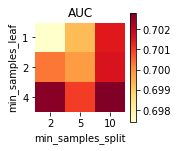

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False) 0.7027888004901222


In [58]:
clf_models = pf.fitModels(RandomForestClassifier(), clf_paramGrid, X_train, y_train)
clf_scores = pf.scoreModels(clf_models, X_val, y_val, metric=roc_auc_score, predict_proba=True)
pf.plotScores(clf_scores, clf_paramGrid, 'AUC')
clf_bestModel = pf.getBestModel(clf_models, clf_scores, greater_is_better=True)
clf_bestScore = pf.getBestScore(clf_scores, greater_is_better=True)
print(clf_bestModel, clf_bestScore)

Initializing the hyperparameterized models and running RFECV for feature selection starting with the LogisticRegression model. The model selects all but horzapproachangle.

Selected Features: [ True  True  True  True  True  True  True  True  True  True False  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 2 1]


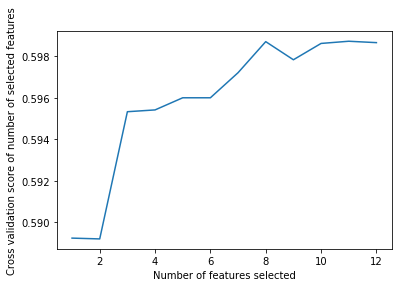

In [63]:
logreg = LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg.fit(X_train,y_train)

rfe = RFECV(logreg,step=1,cv=5)
rfe.fit(X_train,y_train)

print(("Selected Features: %s") % rfe.support_)
print(("Feature Ranking: %s") % rfe.ranking_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

SGD, using the same method, selected all features.

Selected Features: [ True  True False  True  True  True False  True  True  True False  True]
Feature Ranking: [1 1 4 1 1 1 3 1 1 1 2 1]


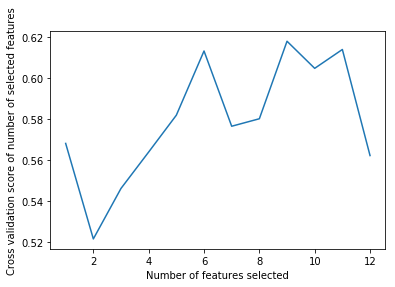

In [64]:
sgd = SGDClassifier(alpha=1e-06, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=1000,
       n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

sgd.fit(X_train, y_train)

rfe = RFECV(sgd,step=1,cv=5)
rfe.fit(X_train,y_train)
print(("Selected Features: %s") % rfe.support_)
print(("Feature Ranking: %s") % rfe.ranking_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1]


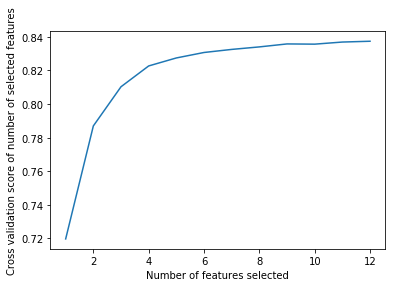

In [65]:
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf.fit(X_train,y_train)

rfe = RFECV(clf,step=1,cv=5)
rfe.fit(X_train,y_train)
print(("Selected Features: %s") % rfe.support_)
print(("Feature Ranking: %s") % rfe.ranking_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

Taking the results from RFE to build the final models for model selection.

In [94]:
names_log = ['pitchresult','releasespeed','pitchtimetoplate','spinaxis','spinrate','horzbreakpfx','vertbreakpfx','releaseheight','extension','vertapproachangle','batside']
scale_names_log = ['releasespeed','pitchtimetoplate','spinaxis','spinrate','horzbreakpfx','vertbreakpfx','releaseheight','extension','vertapproachangle']
data_log = raw_data.loc[:,names_log].copy()

y_log = data_log.pop('pitchresult').values
y_log = np.ravel(y_log)
print(data_log.shape)
data_log[scale_names_log] = StandardScaler().fit_transform(data_log[scale_names_log])

(173887, 10)


In [95]:
names_sgd = ['pitchresult','releasespeed','pitchtimetoplate','spinrate','horzbreakpfx','releaseheight','extension','vertapproachangle','batside']
scale_names_sgd = ['releasespeed','pitchtimetoplate','spinrate','horzbreakpfx','releaseheight','extension','vertapproachangle']
data_sgd = raw_data.loc[:,names_sgd].copy()

y_sgd = data_sgd.pop('pitchresult').values
y_sgd = np.ravel(y_sgd)
print(data_sgd.shape)
data_sgd[scale_names_sgd] = StandardScaler().fit_transform(data_sgd[scale_names_sgd])

(173887, 8)


In [96]:
names_clf = ['pitchresult','releasespeed','pitchtimetoplate','spinaxis','spinrate','horzbreakpfx','vertbreakpfx','releaseheight','releaseside','extension','vertapproachangle','horzapproachangle','batside']
scale_names_clf = ['releasespeed','pitchtimetoplate','spinaxis','spinrate','horzbreakpfx','vertbreakpfx','releaseheight','releaseside','extension','vertapproachangle','horzapproachangle']


data_clf = raw_data.loc[:,names_clf].copy()

y_clf = data_clf.pop('pitchresult').values
y_clf = np.ravel(y_clf)
print(data_clf.shape)
data_clf[scale_names_clf] = StandardScaler().fit_transform(data[scale_names_clf])

(173887, 12)


In [97]:
X_int_log, X_test_log, y_int_log, y_test_log = train_test_split(data_log, y_log,test_size=0.2, random_state=42)
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(X_int_log, y_int_log, test_size=0.25, random_state=42)
del(X_int_log,y_int_log)

X_int_sgd, X_test_sgd, y_int_sgd, y_test_sgd = train_test_split(data_sgd, y_sgd,test_size=0.2, random_state=42)
X_train_sgd, X_val_sgd, y_train_sgd, y_val_sgd = train_test_split(X_int_sgd, y_int_sgd, test_size=0.25, random_state=42)
del(X_int_sgd,y_int_sgd)

X_int_clf, X_test_clf, y_int_clf, y_test_clf = train_test_split(data_log, y_log,test_size=0.2, random_state=42)
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(X_int_clf, y_int_clf, test_size=0.25, random_state=42)
del(X_int_clf,y_int_clf)

Taking the hyperparameter optimization to build the final models for model selection

In [71]:
logreg = LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logreg.fit(X_train_log,y_train_log)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [81]:
sgd = SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=1000,
       n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

sgd.fit(X_train_sgd, y_train_sgd)

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=1000,
       n_jobs=-1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [80]:
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

clf.fit(X_train_clf,y_train_clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Scoring the models.

In [78]:
y_pred_log = logreg.predict(X_val_log)
r2 = logreg.score(X_val_log, y_val_log)
y_pred_log_prob = logreg.predict_proba(X_val_log)[:,1]
print(confusion_matrix(y_val_log,y_pred_log))
print(classification_report(y_val_log,y_pred_log))
print("Tuned Logistic Regression R squared: {}".format(r2))

fpr_log, tpr_log, thresholds = roc_curve(y_val_log, y_pred_log_prob)
roc_auc_log = roc_auc_score(y_val_log, y_pred_log_prob)
cv_auc_log = cross_val_score(logreg,X_train_log,y_train_log,cv=5,scoring='roc_auc')
print("AUC: {}".format(roc_auc_log))
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc_log))

optimal_idx_log = np.argmax(np.abs(tpr_log - fpr_log))
optimal_threshold_log = thresholds[optimal_idx_log]

print("Youden's J Statistic: {}".format(optimal_threshold_log))

[[17135 12347]
 [ 1922  3374]]
             precision    recall  f1-score   support

        0.0       0.90      0.58      0.71     29482
        1.0       0.21      0.64      0.32      5296

avg / total       0.79      0.59      0.65     34778

Tuned Logistic Regression R squared: 0.5897118868250043
AUC: 0.6365732965026948
AUC scores computed using 5-fold cross-validation: [0.6341096  0.63037309 0.63347914 0.63137188 0.63548422]
Youden's J Statistic: 0.523416149245309


In [82]:
y_pred_sgd = sgd.predict(X_val_sgd)
r2 = sgd.score(X_val_sgd, y_val_sgd)
y_pred_sgd_prob = sgd.predict_proba(X_val_sgd)[:,1]
print(confusion_matrix(y_val_sgd,y_pred_sgd))
print(classification_report(y_val_sgd,y_pred_sgd))
print("Tuned SGD Classifier R squared: {}".format(r2))

fpr_sgd, tpr_sgd, thresholds = roc_curve(y_val_sgd, y_pred_sgd_prob)
roc_auc_sgd = roc_auc_score(y_val_sgd, y_pred_sgd_prob)
cv_auc_sgd = cross_val_score(sgd,X_train_sgd,y_train_sgd,cv=5,scoring='roc_auc')
print("AUC: {}".format(roc_auc_sgd))
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc_sgd))

optimal_idx_sgd = np.argmax(np.abs(tpr_sgd - fpr_sgd))
optimal_threshold_sgd = thresholds[optimal_idx_sgd]

print("Youden's J Statistic: {}".format(optimal_threshold_sgd))

[[15493 13989]
 [ 1739  3557]]
             precision    recall  f1-score   support

        0.0       0.90      0.53      0.66     29482
        1.0       0.20      0.67      0.31      5296

avg / total       0.79      0.55      0.61     34778

Tuned SGD Classifier R squared: 0.5477600782103629
AUC: 0.6315538735192203
AUC scores computed using 5-fold cross-validation: [0.62460368 0.62866544 0.63146241 0.62566981 0.63103095]
Youden's J Statistic: 0.5296349938002518


In [85]:
y_pred_clf = clf.predict(X_val_clf)
r2 = clf.score(X_val_clf, y_val_clf)
y_pred_clf_prob = clf.predict_proba(X_val_clf)[:,1]
print(confusion_matrix(y_val_clf,y_pred_clf))
print(classification_report(y_val_clf,y_pred_clf))
print("Tuned Random Forest R squared: {}".format(r2))

fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_val_clf, y_pred_clf_prob)
roc_auc_clf = roc_auc_score(y_val_clf, y_pred_clf_prob)
cv_auc_clf = cross_val_score(clf,X_train_clf,y_train_clf,cv=5,scoring='roc_auc')
print("AUC: {}".format(roc_auc_clf))
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc_clf))

optimal_idx_clf = np.argmax(np.abs(tpr_clf - fpr_clf))
optimal_threshold_clf = thresholds[optimal_idx_clf]

print("Youden's J Statistic: {}".format(optimal_threshold_clf))

[[28317  1165]
 [ 4498   798]]
             precision    recall  f1-score   support

        0.0       0.86      0.96      0.91     29482
        1.0       0.41      0.15      0.22      5296

avg / total       0.79      0.84      0.80     34778

Tuned Random Forest R squared: 0.8371671746506412
AUC: 0.6827832157201352
AUC scores computed using 5-fold cross-validation: [0.68602467 0.67771887 0.68658529 0.68323179 0.67551709]
Youden's J Statistic: 0.5401798526327107


Plotting ROC Curve and Youden's Index.

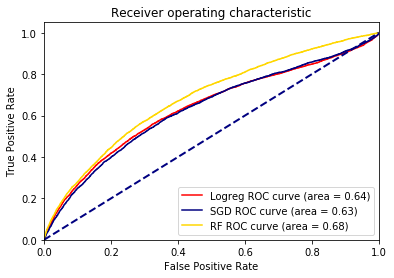

In [90]:
%matplotlib inline
plt.figure()
lw = 2
x_axis = np.linspace(0,1,10)
plt.plot(fpr_log, tpr_log, color='red', label='Logreg ROC curve (area = %0.2f)' % roc_auc_log)
plt.plot(fpr_sgd, tpr_sgd, color='navy', label='SGD ROC curve (area = %0.2f)' % roc_auc_sgd)
plt.plot(fpr_clf, tpr_clf, color='gold', label='RF ROC curve (area = %0.2f)' % roc_auc_clf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

I am selecting the Random Forest Classifier for the final model. The R^2 and AUC metrics were both substantially better than the LogisticRegression and SGDClassifier models. However, I have concerns about the Recall and F-1 Score. 

In [91]:
%matplotlib inline
plt.figure()
lw = 2
x_axis = np.linspace(0,1,10)
plt.plot(fpr_log, tpr_log, color='red', label='Logreg ROC curve (area = %0.2f)' % roc_auc_log)
plt.plot(fpr_sgd, tpr_sgd, color='navy', label='SGD ROC curve (area = %0.2f)' % roc_auc_sgd)
plt.plot(fpr_clf, tpr_clf, color='gold', label='RF ROC curve (area = %0.2f)' % roc_auc_clf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

[[28353  1153]
 [ 4456   816]]
             precision    recall  f1-score   support

        0.0       0.86      0.96      0.91     29506
        1.0       0.41      0.15      0.23      5272

avg / total       0.80      0.84      0.81     34778

Tuned Random Forest R squared: 0.8387198803841509
AUC: 0.6835785412128311


Plotting the ROC curve for the test model.

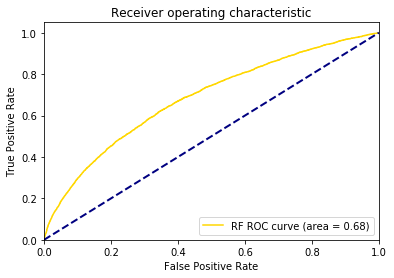

In [93]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(fpr_clf, tpr_clf, color='gold', label='RF ROC curve (area = %0.2f)' % roc_auc_clf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()